## Grant Cloud
## 903194929
## CS-4641 HW3

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot, os.path
from mpl_toolkits.mplot3d import Axes3D

<p>Provided code, with my modified functions</p>

In [2]:
## Data loading utility functions
def get_test_train(fname,seed,datatype):
	'''
	Returns a test/train split of the data in fname shuffled with
	the given seed


	Args:
		fname: 		A str/file object that points to the CSV file to load, passed to
					np.genfromtxt()
		seed:		The seed passed to np.random.seed(). Typically an int or long
		datatype:	The datatype to pass to genfromtxt(), usually int, float, or str


	Returns:
		train_X:	A NxD np array of training data (row-vectors), 80% of all data
		train_Y:	A Nx1 np array of class labels for the training data
		test_X:		A MxD np array of testing data, same format as train_X, 20% of all data
		test_Y:		A Mx1 np array of class labels for the testing data
	'''
	data = np.genfromtxt(fname,delimiter=',',dtype=datatype)
	np.random.seed(seed)
	shuffled_idx = np.random.permutation(data.shape[0])
	cutoff = int(data.shape[0]*0.8)
	train_data = data[shuffled_idx[:cutoff]]
	test_data = data[shuffled_idx[cutoff:]]
	train_X = train_data[:,:-1].astype(float)
	train_Y = train_data[:,-1].reshape(-1,1)
	test_X = test_data[:,:-1].astype(float)
	test_Y = test_data[:,-1].reshape(-1,1)
	return train_X, train_Y, test_X, test_Y


def load_HTRU2(path='data'):
	return get_test_train(os.path.join(path,'HTRU_2.csv'),seed=1567708903,datatype=float)

def load_iris(path='data'):
	return get_test_train(os.path.join(path,'iris.data'),seed=1567708904,datatype=str)

## The "digits" dataset has a pre-split set of data, so we won't do our own test/train split
def load_digits(path='data'):
	train_data = np.genfromtxt(os.path.join(path,'optdigits.tra'),delimiter=',',dtype=float)
	test_data = np.genfromtxt(os.path.join(path,'optdigits.tes'),delimiter=',',dtype=float)
	return train_data[:,:-1], train_data[:,-1].reshape(-1,1), test_data[:,:-1], test_data[:,-1].reshape(-1,1)

## You can use this dataset to debug your implementation
def load_test2(path='data'):
	return get_test_train(os.path.join(path,'data2.dat'),seed=1568572211, datatype=float)

class PCA():
	'''
	A popular feature transformation/reduction/visualization method


	Uses the singular value decomposition to find the orthogonal directions of
	maximum variance.
	'''
	def __init__(self):
		'''
		Initializes some data members to hold the three components of the
		SVD.
		'''
		self.u = None
		self.s = None
		self.v = None
		self.shift = None
		self.data = None

	def find_components(self,data):
		'''
		Finds the SVD factorization and stores the result.


		Args:
			data: A NxD array of data points in row-vector format.
		'''
		self.data = data
		self.shift = self.data - np.mean(data, axis=0) # normalized data
		self.u, self.s, self.v = np.linalg.svd(self.shift, compute_uv=True, full_matrices=False)
		self.v = self.v.T

	def transform(self,n_components,data=None):
		'''
		Uses the values computed and stored after calling find_components()
		to transform the data into n_components dimensions.


		Args:
			n_components: The number of dimensions to transform the data into.
			data: 	the data to apply the transform to. Defaults to the data
					provided on the last call to find_components()


		Returns:
			transformed_data: 	a Nx(n_components) array of transformed points,
								in row-vector format.
		'''
		if data is None:
			data = self.data
		else:
			self.find_components(data)
		return np.dot(data, self.v[:,:n_components])


	def inv_transform(self,n_components,transformed_data):
		'''
		Inverts the results of transform() (if given the same arguments).


		Args:
			n_components:		Number of components to use. Should match
								the dimension of transformed_data.
			transformed_data:	The data to apply the inverse transform to,
								should be in row-vector format


		Returns:
			inv_tform_data:		a NxD array of points in row-vector format
		'''
		#NOTE: Don't forget to "un-center" the data
		tX = np.dot(transformed_data, self.v[:,:n_components].T)
		return tX + np.mean(self.data, axis=0)

	def reconstruct(self,n_components,data=None):
		'''
		Casts the data down to n_components dimensions, and then reverses the transform,
		returning the low-rank approximation of the given data. Defaults to the data
		provided on the last call to find_components().
		'''
		return self.inv_transform(n_components,self.transform(n_components,data))

	def reconstruction_error(self,n_components,data=None):
		'''
		Useful for determining how much information is preserved in n_components dimensions.
		'''
		if data is None:
			data = self.data
		return np.linalg.norm(data-self.reconstruct(n_components,data),ord='fro')

	def plot_2D_proj(self,data=None,labels=None):
		'''
		Creates a 2D visualization of the data, returning the created figure. See
		the main() function for example usage.
		'''
		fig = matplotlib.pyplot.figure()
		proj_2d_data = self.transform(2,data)
		fig.gca().scatter(proj_2d_data[:,0],proj_2d_data[:,1],c=labels)
		fig.gca().set_title('PCA 2D transformation')
		return fig
	def plot_3D_proj(self,data=None,labels=None):
		'''
		Creates a 3D visualization of the data, returning the created figure. See
		the main() function for example usage.
		'''
		fig = matplotlib.pyplot.figure()
		ax = fig.add_subplot(111,projection='3d')
		proj_3d_data = self.transform(3,data)
		ax.scatter(proj_3d_data[:,0],proj_3d_data[:,1],proj_3d_data[:,2],c=labels)
		fig.gca().set_title('PCA 3D transformation')
		return fig



# You may find this method useful for providing a canonical ordering of cluster centers in KMeans.cluster
def consistent_ordering(array):
	rowvec_dists = np.linalg.norm(array,axis=1)
	dist_order = np.argsort(rowvec_dists,kind='stable')
	return array[dist_order,:]
class KMeans():
	'''
	A simple iterative clustering method for real-valued feature spaces.


	Finds cluster centers by iteratively assigning points to clusters and re-computing
	cluster center locations. Provided code expects self.clusters to contain the
	cluster centers in row-vector format.
	'''
	def __init__(self):
		'''
		Initializes data members.
		'''
		self.clusters = None
		self.print_every = 1000

	def cluster_distances(self,data):
		'''
		Computes the distance from each row of data to the cluster centers. Must call KMeans.cluster(), or
		otherwise set self.clusters first.


		Args:
			data:	The data to compute distances for, in row-vector format. Each row should have the
					same number of columns as each cluster


		Returns:
			dists:	A Nx(len(clusters)) array, one row for each row in data, one column for each
					cluster center, containing the distance for each point to each cluster
		'''
		return np.hstack([np.linalg.norm(data-c,axis=1).reshape(-1,1) for c in self.clusters])

	def cluster_label(self,data):
		'''
		Returns the label of the closest cluster to each row in data. Note that these labels are
		arbitrary, and do *not* correspond directly with class labels.


		Args:
			data:	Data to compute cluster labels for, in row-vector format.


		Returns:
			c_labels:	A N-by-1 array, one row for each row in data, containing the integer
						corresponding to the cluster closest to each point.
		'''
		return np.argmin(self.cluster_distances(data),axis=1)

	def cluster(self,data,k):
		'''
		Implements the k-Means iterative algorithm. Cluster centers are initially chosen randomly,
		then on each iteration each data point is assigned to the closest cluster center, and then the
		cluster centers are re-computed by averaging the points assigned to them. After finishing,
		self.clusters should contain a k-by-D array of the cluster centers in row-vector format.


		Args:
			data:	Data to be clustered in row-vector format. A N-by-D array.
			k:		The number of clusters to find.
		'''
		#This line should pick the initial clusters at random from the provided
		#data.
		self.clusters = data[np.random.choice(data.shape[0],k,replace=False),:]
		#An example of how to use the consistent_ordering() function, which you
		#may want to use to help determine if cluster centers have changed from one
		#iteration to the next
		self.clusters = consistent_ordering(self.clusters)
		#We know that k-Means will always converge, but depending on the initial
		#conditions and dataset, it may take a long time. For debugging purposes
		#you might want to set a maximum number of iterations. When implemented
		#correctly, none of the provided datasets take many iterations to converge
		#for most initial configurations.
		not_done = True
		itr = 0
		while not_done:
			itr += 1
			new_clusters = np.zeros(self.clusters.shape)
			#assign points to nearest cluster
			labels = self.cluster_label(data)
			#re-compute cluster centers by averaging the points assigned to them
			for i in range(new_clusters.shape[0]):
				new_clusters[i] = data[np.argwhere(labels==i)].mean(axis=0)
			#determine if clusters have changed from the previous iteration
			new_clusters = consistent_ordering(new_clusters)
			if np.array_equal(self.clusters, new_clusters):
				not_done = False
			#For debugging, print out every so often.
			if itr == 0:
				print('')
			if itr % self.print_every == 0:
				print("Iteration {}, change {}".format(itr,np.linalg.norm(new_clusters-self.clusters,ord='fro')))
			self.clusters = new_clusters
		print("Converged after {} iterations".format(itr))

	def normalized_mutual_information(self, data, labels):
		'''
		Since cluster assignments are not the same as class labels, we can't always directly
		compare them to measure clustering performance. However, we can measure the Mutual Information
		between two labelings, to see if they contain the same statistical information. This method
		implements the "Normalized Mutual Information Score" as described here:

		https://scikit-learn.org/stable/modules/clustering.html#mutual-information-based-scores

		Note that this version uses arithmetic mean, when comparing output with
		sklearn.metrics.mutual_info_score()
		'''
		cluster_labels = self.cluster_label(data)
		P_cl = np.zeros(len(self.clusters))
		P_gt = np.zeros(len(np.unique(labels)))
		P_clgt = np.zeros((len(P_cl),len(P_gt)))
		cl_masks = dict()
		gt_masks = dict()
		MI = 0.0
		H_cl = 0.0
		H_gt = 0.0
		for c_cl in range(len(P_cl)):
			cl_masks[c_cl] = (cluster_labels==c_cl).reshape(-1,1)
			P_cl[c_cl] = (cl_masks[c_cl]).astype(int).sum()/len(data)
			H_cl -= P_cl[c_cl]*np.log(P_cl[c_cl])
		for c_gt in range(len(P_gt)):
			gt_masks[c_gt] = labels == c_gt
			P_gt[c_gt] = (gt_masks[c_gt]).astype(int).sum()/len(data)
			H_gt -= P_gt[c_gt]*np.log(P_gt[c_gt])
		for c_cl in range(len(P_cl)):
			for c_gt in range(len(P_gt)):
				P_clgt[c_cl,c_gt] = (np.logical_and(cl_masks[c_cl], gt_masks[c_gt])).astype(int).sum()/len(data)
				if P_clgt[c_cl,c_gt] == 0.0:
					MI += 0
				else:
					MI += P_clgt[c_cl,c_gt]*np.log(P_clgt[c_cl,c_gt]/(P_cl[c_cl]*P_gt[c_gt]))
		return MI/(np.mean([H_cl,H_gt]))

	def plot_2D_clusterd(self, data, labels=None):
		'''
		Creates a 2D visualization of the data, returning the created figure. See
		the main() function for example usage.
		'''
		if self.clusters is None or len(self.clusters)!=2:
			self.cluster(data,2)
		fig = matplotlib.pyplot.figure()
		clusterd_2d_data = self.cluster_distances(data)
		fig.gca().scatter(clusterd_2d_data[:,0],clusterd_2d_data[:,1],c=labels)
		fig.gca().set_title('k-Means 2D cluster distance')
		return fig
	def plot_3D_clusterd(self, data, labels=None):
		'''
		Creates a 3D visualization of the data, returning the created figure. See
		the main() function for example usage.
		'''
		if self.clusters is None or len(self.clusters)!=3:
			self.cluster(data,3)
		fig = matplotlib.pyplot.figure()
		ax = fig.add_subplot(111,projection='3d')
		clusterd_3d_data = self.cluster_distances(data)
		ax.scatter(clusterd_3d_data[:,0],clusterd_3d_data[:,1],clusterd_3d_data[:,2],c=labels)
		fig.gca().set_title('k-Means 3D cluster distance')
		return fig

### 1a) and 1b)

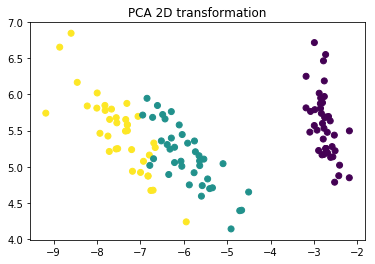

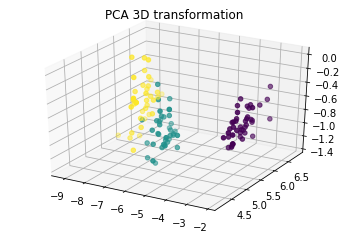

In [3]:
pca = PCA()
data = load_iris()
pca.find_components(data[0])
_,labels = np.unique(data[1],return_inverse=True)
pca.plot_2D_proj(data[0],labels)
pca.plot_3D_proj(data[0],labels)
print('') # prevents Jupyter from repeat printing a figure

In [4]:
reconError = pca.reconstruction_error(2,data[0])
print('2d reconstruction error: ',reconError)
reconError = pca.reconstruction_error(3,data[0])
print('3d reconstruction error: ',reconError)

2d reconstruction error:  82.49015254320533
3d reconstruction error:  82.82381890639289


<p>With the Iris dataset, we expect classification to perform better on the 2D transformed features than on the original dataset. From the 2D transformation plot we can see the purple class is easily distinguished from the other 2 classes, and the remaining 2 classes have very little overlap. This is because PCA projects onto new axis' built from the eigenvalues of the highest variance features in the original dataset (this process is called Truncated SVD), this leads to reduced noise in the transformed data. In this case a good learner would definitely improve performance since we lost little (if any) signal but removed a lot of noise.</p>
<p>For the 3D case, we expect classification to perform about the same or maybe slightly better on the PCA transformed data as with the original features. This is because the Iris dataset only has 4 features, meaning the 3 transformed features contain almost all the same information as the original dataset. The amount of improvement depends on how much noise was contained in the 4th feature not chosen by PCA, as well as how much of that noise was removed when the transformation occurred. From the plot the purple points are still easily classified (same as with the original features) but there looks to be more overlap in the yellow and blue classes than in the case of the 2D transformation. Overall I would expect a classifier to perform better on the 2D transformed data than the 3D transformed data (since the 3D transformed data has additional noise).</p>
<p>For both cases we have about the same reconstruction error, showing the added feature may hold little to no information (and if any it is probably noise).</p>

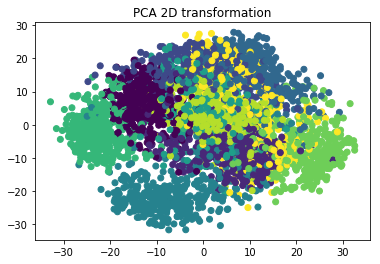

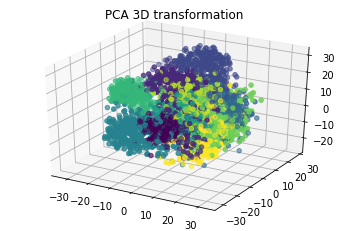

In [5]:
data = load_digits()
pca.find_components(data[0])
_,labels = np.unique(data[1],return_inverse=True)
pca.plot_2D_proj(data[0],labels)
pca.plot_3D_proj(data[0],labels)
print('')

In [6]:
reconError = pca.reconstruction_error(2,data[0])
print('2d reconstruction error: ',reconError)
reconError = pca.reconstruction_error(3,data[0])
print('3d reconstruction error: ',reconError)

2d reconstruction error:  1820.7713792883224
3d reconstruction error:  1673.459624274109


<p>The 2D PCA transformation on the digits dataset would likely decrease classification performance. This is because the digits dataset has so many different class labels. When PCA transforms the data into the lower dimension, we lose information on a lot of features. With so many different class labels, there is bound to be different classes that have similar values for the 2 features PCA chose and the distinguishing factor between these classes might be contained in a feature that was "squished" during the transformation. This loss of signal would decrease classification performance compared to the original feature set that still contains the important information to distinguish between these classes.</p>
<p>For the 3D case, we expect a classifier to perform better on the 3D transformed data than the original dataset. This is because the PCA transformation removes a lot of noise but maintains the information needed for a classifier to perform well (it looks like the additional feature selected in the 3D case contained a lot of signal). It may be the case that the best PCA transformation for the digits dataset would be one in 4D or even higher, since there are so many features and class labels, and there may be important signal in a feature that we lose when we scale down into 3D. We would also expect a classifier to perform better on the 3D PCA transformed data than the 2D PCA transormed data. 
<p>Performance on the digits dataset may also depend on what type of classifier is used. In the previous homework we saw how the high number of classes caused the logistic regression "one-vs-all" approach struggled with a high number of class labels. This would lead to lower performance on this dataset than kNN on the 3D PCA transformed data, which appears to be, in general, well clustered by class label in the plot.</p>

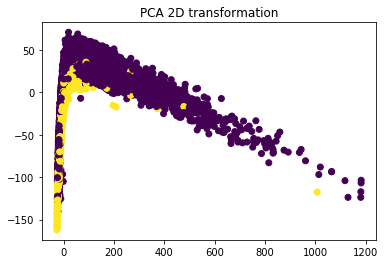

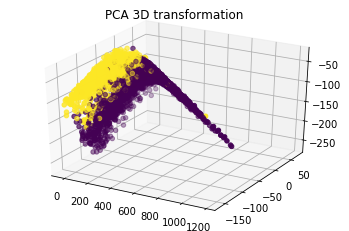

In [7]:
data = load_HTRU2()
pca.find_components(data[0])
_,labels = np.unique(data[1],return_inverse=True)
pca.plot_2D_proj(data[0],labels)
pca.plot_3D_proj(data[0],labels)
print('')

In [8]:
reconError = pca.reconstruction_error(2,data[0])
print('2d reconstruction error: ',reconError)
reconError = pca.reconstruction_error(3,data[0])
print('3d reconstruction error: ',reconError)

2d reconstruction error:  13094.399418771973
3d reconstruction error:  18805.737261371978


<p>The 2D PCA transformation on the HTRU2 dataset would decrease classifier performance. From the 2D plot we see a lot of overlap between the two classes. This is occurs because PCA chooses the two highest variance features (with the underlying assumption that they provide the most information about the data), but this can be flawed when there is a high variance, noisy feature. This feature might be highly variant but actually provides little to no information about the underlying classes of the data points. This is also the most likely reason that we see both classes occuring at both ends of the plot and a lot of overlap between classes. A classifier would struggle to classify the PCA transformed data using noisy features that contain little to no actual information about the underlying classes.</p>
<p>In the 3D PCA transformed data we see a much more distinguishable seperation of classes. The additional feature selected by PCA clearly contains important information about the underlying class of each data point. Furthermore the transformation squished other less variant features that may contain a lot of noise. It's interesting to note that we have a higher reconstruction error and higher classifier performance with the 3D transformation. This is shows that the additional "information" lost when we project onto the additional axis is mostly noise and isn't all that useful for a classifier in practice.</p>

### 2a) and 2b)

Converged after 6 iterations
Converged after 5 iterations



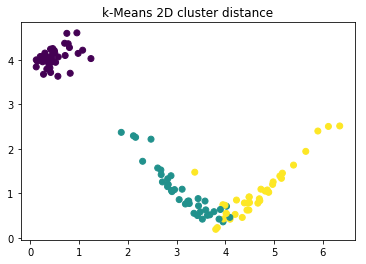

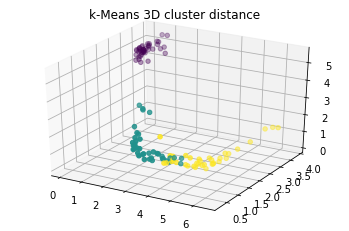

In [9]:
km = KMeans()
data = load_iris()
_,labels = np.unique(data[1],return_inverse=True)
km.plot_2D_clusterd(data[0],labels)
km.plot_3D_clusterd(data[0],labels)
print('')

<p>kMeans would be a better transformation than PCA in the 2D case because the clusters look to be perpindicular, whereas in the PCA transform they have similar shape and size. It's easy to distinguish them when the class labels are present but when those labels are not present it would be much harder to distinguish the different classes in the 2D PCA transformation. In general I would expect a classifier to perform better when there are less points with different class labels next to each other in the 2D visualization and minimal overlap between classes.</p>
<p>In the 3D case I would expect a classifier to perform about equally on the PCA transformed data as the kMeans transformed data. Both transformation have a pretty clear seperation of class labels with some small overlap between two of the classes which would potentially lead to some loss in a classifier.</p>

Converged after 10 iterations
Converged after 25 iterations



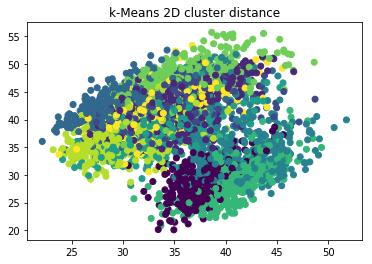

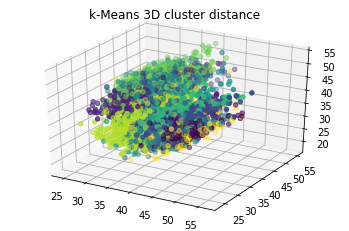

In [11]:
data = load_digits()
_,labels = np.unique(data[1],return_inverse=True)
km.plot_2D_clusterd(data[0],labels)
km.plot_3D_clusterd(data[0],labels)
print('')

<p>For both the 2D and 3D case in the digits dataset, the PCA transformation should be preferred to the kMeans transformation in terms of expected classifier performance. In both 2D and 3D kMeans transformations we see a large amount of overlap between different class labels and the clusters of classes are loose and wide. While the 2D PCA transformation probably wouldn't help classifier performance because of so much overlap between classes, the clustering of class labels was still tighter, and the 3D PCA transformation had clear clusters by different class labels with much less overlap. Overall a classifier would really struggle with classifying the kMeans transformed data.</p>

2D : Converged after 23 iterations
3D : Converged after 44 iterations



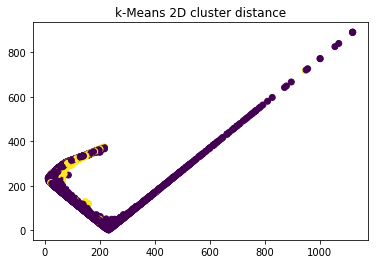

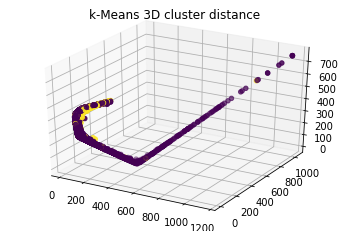

In [12]:
data = load_HTRU2()
_,labels = np.unique(data[1],return_inverse=True)
print('2D : ', end='')
km.plot_2D_clusterd(data[0],labels)
print('3D : ', end='')
km.plot_3D_clusterd(data[0],labels)
print('')

<p>In both the 2D and 3D cases PCA is absolutely the preferred transformation in terms of best classifier performance. The kMeans transformed data makes it virtually impossible to distinguish between class labels. There is so much overlap between different classes, a classifier would struggle to distinguish different classes. The 2D PCA transformation, while still not super helpful for classifier performance, still has slightly easier to distinguish classes than the 2D kMeans transformed data. The 3D PCA transformation has a clear seperability between classes, that seperability is non-existant in the 3D kMeans transformed data plot.</p>

### 2c)

In [13]:
km = KMeans()
data = load_iris()
_,labels = np.unique(data[1],return_inverse=True)
numClasses = len(np.unique(labels))
print('# of Classes: ',numClasses)
km.cluster(data[0],numClasses)

# changing dtype to float for mutual information scoring 
i = 0
for classLabel in list(np.unique(data[1])):
    data[1][data[1]==classLabel] = i
    i += 1

print('Mutual Information Score: ',km.normalized_mutual_information(data[0],data[1].astype('float64')))

# of Classes:  3
Converged after 14 iterations
Mutual Information Score:  0.5909010603830261


<p>kMeans did an ok job of clustering by class label on the iris dataset. This is because there is overlap between different class labels in the Iris dataset. When kMeans assigns points to clusters the assigned cluster is the one with the smallest distance from the point. This causes similar points with different class labels to be a part of the same cluster, decreasing the mutual information score. In the case of the Iris dataset, the 0.591 mutual information score means there <b>is</b> a statistical relationship between class label and cluster assignments (both labelings contain similar information), but it is not a perfect indicator.</p>

In [16]:
km = KMeans()
data = load_digits()
_,labels = np.unique(data[1],return_inverse=True)
numClasses = len(np.unique(labels))
print('# of Classes: ',numClasses)
km.cluster(data[0],numClasses)
print('Mutual Information Score: ',km.normalized_mutual_information(data[0],data[1]))

# of Classes:  10
Converged after 48 iterations
Mutual Information Score:  0.7543227044445462


<p>kMeans did the best job clustering according to class labels on the digits dataset, with the highest mutual information score of 0.745 . This tells us that the clusters and labelings both contain similar information (there is a strong statistical relationship). We also notice that it took the most iterations to converge of all the datasets, this is because kMeans converges when cluster assignments no longer change from one iteration to the next. In the case of digits, there are 10 class labels. The high number of clusters means that more points are likely to be reassigned from one iteration to the next (since there are more potential assignments). Digits has such a high mutual information score because data points that have the same class label have similar distances to the different cluster centers (mean of all the points assigned to a cluster).</p>

In [15]:
km = KMeans()
data = load_HTRU2()
_,labels = np.unique(data[1],return_inverse=True)
numClasses = len(np.unique(labels))
print('# of Classes: ',numClasses)
km.cluster(data[0],numClasses)
print('Mutual Information Score: ',km.normalized_mutual_information(data[0],data[1]))

# of Classes:  2
Converged after 23 iterations
Mutual Information Score:  0.024972522126462778


<p>kMeans did the worst job clustering according to class labels on the HTRU2 dataset, with a mutual information score of 0.025 . This tells us that there is almost no statistical relationship between clusters and class labels. This also means the clusters are not representative of class labels. It's worth noting that kMeans can get stuck in local optima, it's possible that the converged cluster centers are not global optima and we would need to impliment random restarts to help address this issue. The poor mutual information score most likely is caused by noisy features in the dataset, these features would have a large impact on cluster assignments (because of high distances) and no correlation to class labels.</p>